In [1]:
# imports and prep

import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import openmdao.api as om

# use a dark background for plotting
plt.style.use(["dark_background"])

# LCOE Stack Demo

In this demo analysis, we will analyze the `Ard` layout-to-LCOE stack for land-based analysis.
First, `Ard` must be installed, and the test case in `test/system/LCOE_stack` relative to the `Ard` root directory.

Assuming these are done and `Ard` has been installed cleanly, you should be able to run an LCOE optimization problem by typing
```shell
python LCOE_demo.py
```
at the command line with the current working directory set to that which holds this file.
The result is that an output directory `LCOE_demo_out` should be created, and a directory `case_files` holding configuration files to allow repeatable re-run analyses.

In the next section, we will detail what the optimization case in `LCOE_demo.py` does.

## Optimization code description

In `LCOE_demo.py`, we built out a demonstration of totally stock `Ard` run.
We start with wind dataset `../data/wrg_example.wrg`, [which is borrowed directly form the FLORIS dataset](https://github.com/NREL/floris/blob/fd0e599ef01dc9f1d426d2b4c99e2f6beb57fefd/examples/examples_wind_resource_grid/wrg_example.wrg).
Then, a wind turbine is specified via an `Ard` input file, which generalizes the collective of variables that will define the design and costs of a wind turbine, across various tools.
We then set up the OpenMDAO problem which consists of:

1. a layout component to map from orientation angle, primary and perpendicular spacing, and skew angle parameters (4 total) to $(x,y)$ locations for 25 turbines
2. a land use component to map from the parameterized layout (or a raw layout) to a measure of the land used by the farm
3. a FLORIS AEP component to compute AEP given the turbines and layout
4. a WISDEM-based turbine capital costs component
5. a component for BOS using LandBOSSE
6. a WISDEM-based operating and maintenance component
7. a WISDEM-based plant finance integration component
   
These are brought together in order to either run a single top-down analysis run or an optimization run (the default), which will run for 25 iterations by default.
In the latter case, the code will save the variables active in the optimization to a recorder called `case.sql`.
Finally, the code will output to the CLI the AEP (annual energy production), the ICC (initial capital costs), consisting of broken out CapEx (capital expenditures) and BOS (balance-of-station), the annual OpEx (operational expenditures), and the LCOE (levelized cost of energy).

In [2]:
# load the results

# get the case data from the OpenMDAO optimization
cr = om.CaseReader(os.path.join("LCOE_demo_out", "case.sql"))
driver_cases = cr.list_cases("driver", out_stream=None)

# extract the relevant optimization variables
objective_values = {}
constraint_values = {}
design_variables = {}

# initialize all the data variables
case_init = cr.get_case(driver_cases[0])
for k_obj in case_init.get_objectives().keys():
    objective_values[k_obj] = []
for k_cons in case_init.get_constraints().keys():
    constraint_values[k_cons] = []
for k_DV in case_init.get_design_vars().keys():
    design_variables[k_DV] = []

# then populate them
for case in [cr.get_case(v) for v in driver_cases]:
    for k_obj, v_obj in case.get_objectives().items():
        objective_values[k_obj].append(np.array(v_obj))
    for k_cons, v_cons in case.get_constraints().items():
        constraint_values[k_cons].append(np.array(v_cons))
    for k_DV, v_DV in case.get_design_vars().items():
        design_variables[k_DV].append(np.array(v_DV))

# create some pretty variable names:
title_map = {
    "financese.lcoe": "levelized cost of energy, $\\mathrm{LCOE}^{(i)}$ (\\$/MWh)",
    "spacing_primary": "primary axis spacing ($D_{\\mathrm{rotor}}$)",
    "spacing_secondary": "secondary axis spacing ($D_{\\mathrm{rotor}}$)",
    "angle_orientation": "orientation angle (degrees)",
    "angle_skew": "skew angle (degrees)",
}

## Analysis

Given the result of the last iteration analysis, we can now explore how the optimization arrived at it.
In the next few sections, we show the path of the optimizer.

### Objective function

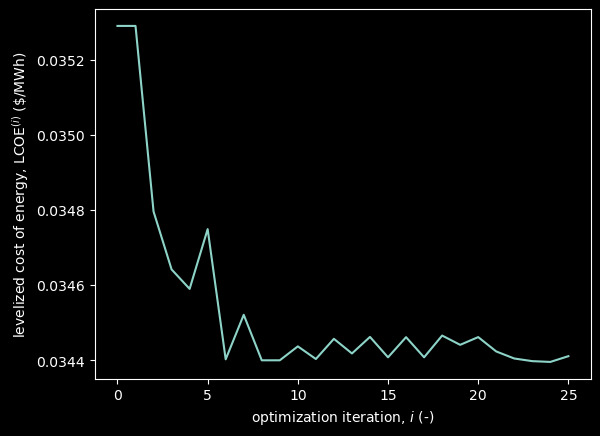

In [3]:
# plot the objective function of the optimization problem
fig, ax = plt.subplots()
for name_obj, values_obj in objective_values.items():
    ax.plot(values_obj, label=title_map[name_obj])
ax.set_xlabel("optimization iteration, $i$ (-)")
ax.set_ylabel(title_map[name_obj])
plt.show()

### Constraints

There are actually no constraints on this problem so the next block won't output anything...

In [4]:
# plot the constraint function of the optimization problem
if constraint_values.keys():
    fig, axes = plt.subplots(len(constraint_values.keys()), 1, sharex=True)
    for idx_cons, (name_cons, values_cons) in enumerate(constraint_values.items()):
        print(name_cons)
        axes[idx_cons].plot(values_cons, label=name_cons)
        axes[idx_cons].set_ylabel(title_map[name_cons])
    axes[-1].set_xlabel("optimization iteration, $i$ (-)")
plt.show()

### Design variables

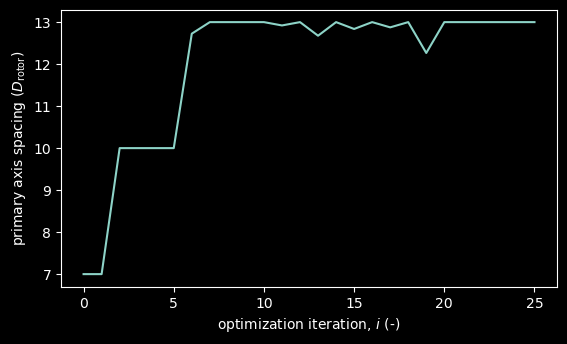

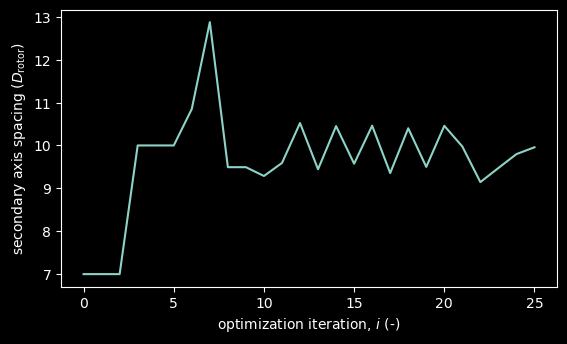

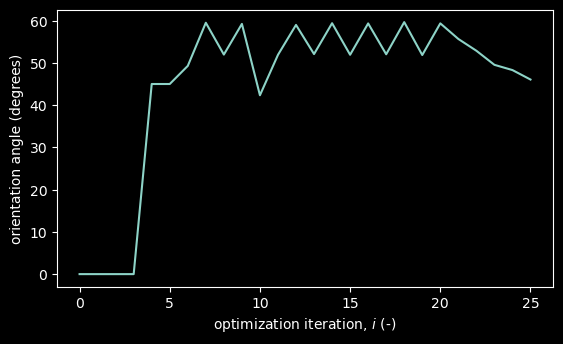

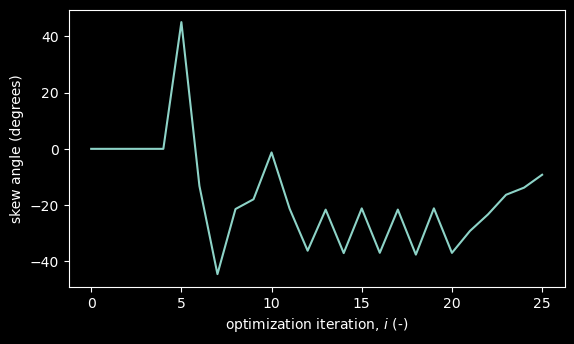

In [5]:
# plot the design variables of the optimization problem
for idx_DV, (name_DV, values_DV) in enumerate(design_variables.items()):
    fig, ax = plt.subplots(figsize=(6.4, 3.6))
    ax.plot(values_DV, label=name_DV)
    ax.set_xlabel("optimization iteration, $i$ (-)")
    ax.set_ylabel(title_map[name_DV])
plt.show()

## Conclusion

These results show that the optimization, through 25 iterations delivers around $1/MWh of savings.
These are realized by orienting the farm by more than 45°, increasing the spacing of the farm, and skewing it.